# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

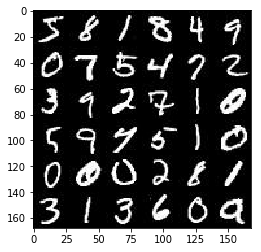

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

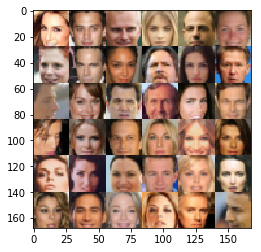

In [3]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/Users/Beck/anaconda/envs/tflearn/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(
        tf.float32, 
        [None, image_width, image_height, image_channels], 
        name="input_real")
    inputs_z = tf.placeholder(
        tf.float32, 
        [None, z_dim], 
        name="input_z")
    learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [86]:
def discriminator(images, reuse=False, alpha = 0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 32, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(lrelu1, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm1 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm1, batch_norm1)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(lrelu2, 128, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm2 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm2, batch_norm2)
        # 4x4x256
        
        conv4 = tf.layers.conv2d(lrelu3, 256, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm3 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = tf.maximum(alpha * batch_norm3, batch_norm3)
        # 2x2x512
       
        # Flatten it
        flat = tf.reshape(lrelu4, (-1, 2*2*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [87]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if is_train==True:
        reuse = False
    else:
        reuse = True
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=reuse):
        # First fully connected layer
        fc1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        reshape = tf.reshape(fc1, (-1, 4, 4, 512))
        batch_norm1 = tf.layers.batch_normalization(reshape, training=is_train)
        lrelu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        print('LRELU1', lrelu1.shape)

        deconv1 = tf.layers.conv2d_transpose(lrelu1, 128, 4, strides=1, padding='valid')
        batch_norm2 = tf.layers.batch_normalization(deconv1, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        print('LRELU2', lrelu2.shape)
        # 4x4x256
        
        deconv2 = tf.layers.conv2d_transpose(lrelu2, 64, 5, 2, 'same')
        batch_norm3 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        print('LRELU3', lrelu3.shape)
        # 7x7x128
        
        
        deconv3 = tf.layers.conv2d_transpose(lrelu3, 32, 5, 2, 'same')
        batch_norm4 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        print('LRELU4', lrelu4.shape)
        # 14x14x64
        
        # Logits
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, 1, 'same')
        # Output
        output = tf.tanh(logits)
        
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

LRELU1 (?, 2, 2, 256)
LRELU2 (?, 4, 4, 128)
LRELU3 (?, 7, 7, 64)
LRELU4 (?, 14, 14, 32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [84]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Optimizers

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == "L":
        out_channel_dim = 1
    else:
        out_channel_dim = 3
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                print(batch_images)
                batch_images *= 2 
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        learn_rate: learning_rate})
                _ = sess.run(g_train_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train = False),
                                   feed_dict={input_z: batch_z})
                    
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
Epoch 1/2... Discriminator Loss: 4.9965... Generator Loss: 0.0099
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 5.4997
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 0.6750
Epoch 1/2... Discriminator Loss: 0.8402... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.4790
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.6327
Epoch 1/2... Discriminator Loss: 2.0258... Generator Loss: 0.2123
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.8032
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


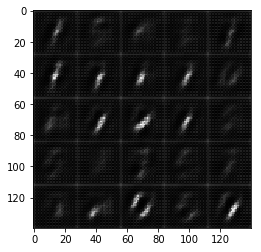

Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.8412
Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 1.7119
Epoch 1/2... Discriminator Loss: 2.5769... Generator Loss: 3.5336
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 2.5160
Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 1.3996
Epoch 1/2... Discriminator Loss: 2.3579... Generator Loss: 0.9884
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 1.8161
Epoch 1/2... Discriminator Loss: 1.6157... Generator Loss: 0.3664
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 1.1228
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


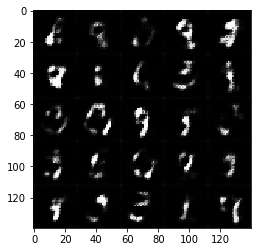

Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 1.5313
Epoch 1/2... Discriminator Loss: 1.8480... Generator Loss: 2.9629
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 1.6332
Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 1.0496
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 0.5327
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 1.1910
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 1.4364
Epoch 1/2... Discriminator Loss: 1.5383... Generator Loss: 1.5358
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 1.4442
Epoch 1/2... Discriminator Loss: 1.4683... Generator Loss: 1.0854
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


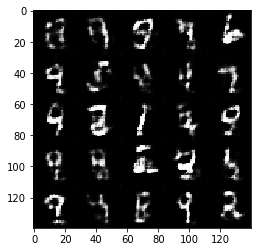

Epoch 1/2... Discriminator Loss: 1.9439... Generator Loss: 2.4404
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.8325
Epoch 1/2... Discriminator Loss: 1.6177... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 1.4171... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.6702
Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 3.7819... Generator Loss: 0.0763
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.2848... Generator Loss: 0.7089
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


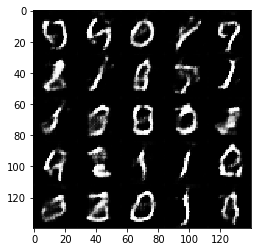

Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.5832
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 1.1929
Epoch 1/2... Discriminator Loss: 1.0307... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 1.4966
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.8686
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.0518
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 1.3413
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 1.3731
Epoch 1/2... Discriminator Loss: 1.6820... Generator Loss: 2.1794
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


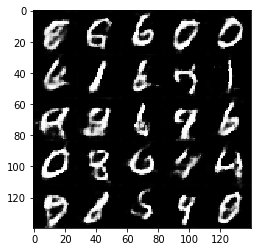

Epoch 1/2... Discriminator Loss: 2.1442... Generator Loss: 1.8014
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.6268
Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.3840
Epoch 1/2... Discriminator Loss: 1.9954... Generator Loss: 0.2427
Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 0.3984
Epoch 1/2... Discriminator Loss: 1.8238... Generator Loss: 0.3180
Epoch 1/2... Discriminator Loss: 1.5890... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 1.7834... Generator Loss: 0.2959
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.4552
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


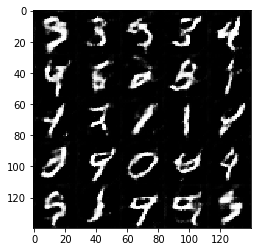

Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 1.0562
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 1.8758... Generator Loss: 1.9356
Epoch 1/2... Discriminator Loss: 1.0927... Generator Loss: 0.8108
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 1.7069
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 1.3348
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.6451
Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.4248
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.4848
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


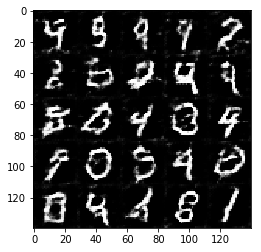

Epoch 1/2... Discriminator Loss: 0.9942... Generator Loss: 1.4416
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 1.5807
Epoch 1/2... Discriminator Loss: 2.0261... Generator Loss: 2.2026
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 1.6640... Generator Loss: 0.3795
Epoch 1/2... Discriminator Loss: 1.8771... Generator Loss: 0.2650
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 1.3861
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 1.1095
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


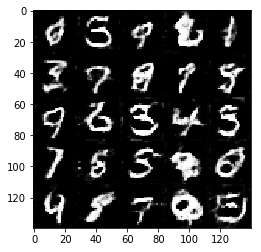

Epoch 1/2... Discriminator Loss: 1.7873... Generator Loss: 0.3016
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.6287... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 0.8726... Generator Loss: 1.3037
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 1.7638
Epoch 1/2... Discriminator Loss: 1.4791... Generator Loss: 0.4223
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 0.9333
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 1.3281
Epoch 1/2... Discriminator Loss: 1.6123... Generator Loss: 0.6422
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


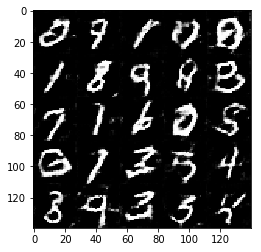

Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 0.9489
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.5400... Generator Loss: 1.9612
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 1.3320
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 1.1162
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 1.6026
Epoch 2/2... Discriminator Loss: 1.6862... Generator Loss: 2.1971
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 0.4921
Epoch 2/2... Discriminator Loss: 2.1760... Generator Loss: 0.2001
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


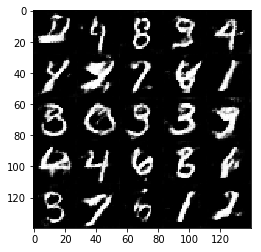

Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 0.6488
Epoch 2/2... Discriminator Loss: 2.2067... Generator Loss: 0.2223
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.7553
Epoch 2/2... Discriminator Loss: 1.6412... Generator Loss: 0.3838
Epoch 2/2... Discriminator Loss: 1.6106... Generator Loss: 0.3603
Epoch 2/2... Discriminator Loss: 1.7169... Generator Loss: 2.1221
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 1.2359... Generator Loss: 0.6185
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


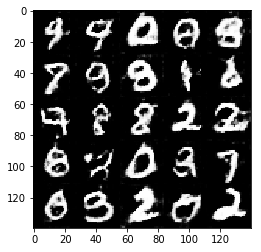

Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 1.2661
Epoch 2/2... Discriminator Loss: 0.7307... Generator Loss: 1.3649
Epoch 2/2... Discriminator Loss: 1.5897... Generator Loss: 0.3758
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.5246
Epoch 2/2... Discriminator Loss: 1.7638... Generator Loss: 0.2917
Epoch 2/2... Discriminator Loss: 1.8757... Generator Loss: 0.2750
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.5315
Epoch 2/2... Discriminator Loss: 1.6520... Generator Loss: 0.3306
Epoch 2/2... Discriminator Loss: 1.1892... Generator Loss: 0.6734
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.5038
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


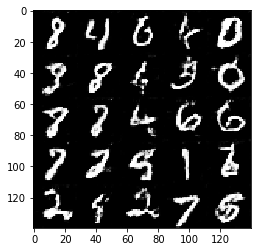

Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.8595
Epoch 2/2... Discriminator Loss: 2.0639... Generator Loss: 0.2457
Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.4957
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 1.5165... Generator Loss: 0.6328
Epoch 2/2... Discriminator Loss: 1.9370... Generator Loss: 0.2894
Epoch 2/2... Discriminator Loss: 1.5555... Generator Loss: 0.3816
Epoch 2/2... Discriminator Loss: 2.0777... Generator Loss: 0.2149
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.1141
Epoch 2/2... Discriminator Loss: 0.9629... Generator Loss: 1.5651
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


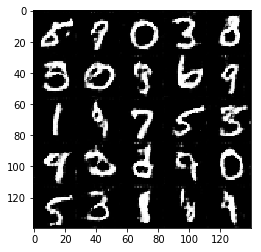

Epoch 2/2... Discriminator Loss: 1.7620... Generator Loss: 1.9989
Epoch 2/2... Discriminator Loss: 1.4729... Generator Loss: 0.4561
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 1.4032
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.5151
Epoch 2/2... Discriminator Loss: 1.6141... Generator Loss: 0.3549
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.5040
Epoch 2/2... Discriminator Loss: 1.3785... Generator Loss: 1.9438
Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 1.4795
Epoch 2/2... Discriminator Loss: 1.4889... Generator Loss: 2.0642
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


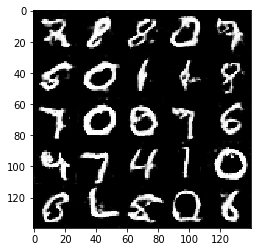

Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.2701
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 2.1093
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 1.9098
Epoch 2/2... Discriminator Loss: 1.7074... Generator Loss: 0.3660
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.5592
Epoch 2/2... Discriminator Loss: 0.5777... Generator Loss: 2.6833
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 1.1905
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.7600
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 2.6556
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


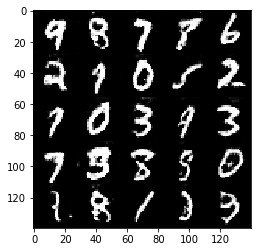

Epoch 2/2... Discriminator Loss: 1.1139... Generator Loss: 0.9098
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 1.5814
Epoch 2/2... Discriminator Loss: 2.1357... Generator Loss: 0.3320
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 1.0205
Epoch 2/2... Discriminator Loss: 1.8274... Generator Loss: 2.8818
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 2.0930
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 1.3947
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.6192
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


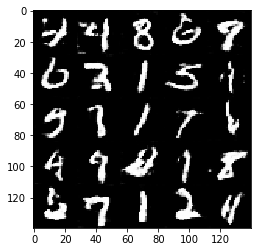

Epoch 2/2... Discriminator Loss: 1.4794... Generator Loss: 0.5610
Epoch 2/2... Discriminator Loss: 1.5229... Generator Loss: 2.2203
Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 1.1085
Epoch 2/2... Discriminator Loss: 1.7997... Generator Loss: 0.3105
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.4781
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.5077
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.4685
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 2.4545
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.6202... Generator Loss: 0.3710
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


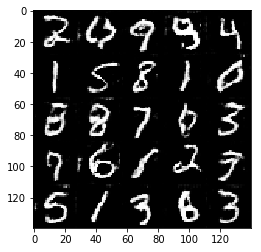

Epoch 2/2... Discriminator Loss: 1.4407... Generator Loss: 0.4802
Epoch 2/2... Discriminator Loss: 1.7422... Generator Loss: 0.9476
Epoch 2/2... Discriminator Loss: 0.8253... Generator Loss: 1.1393
Epoch 2/2... Discriminator Loss: 2.0855... Generator Loss: 0.2138
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 2.6717
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 0.5082
Epoch 2/2... Discriminator Loss: 1.2017... Generator Loss: 0.6209
Epoch 2/2... Discriminator Loss: 1.2408... Generator Loss: 0.5705
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.6460
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


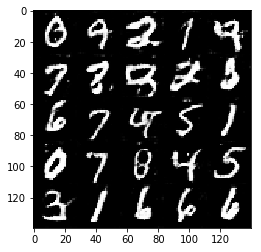

Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.4590
Epoch 2/2... Discriminator Loss: 1.6224... Generator Loss: 0.3938
Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 1.5784
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 1.8334
Epoch 2/2... Discriminator Loss: 1.8669... Generator Loss: 0.3237


In [85]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 4.5395
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 2.3831
Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.6223
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.9179
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


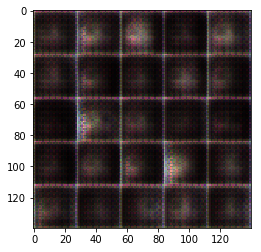

Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 1.5007
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6233
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


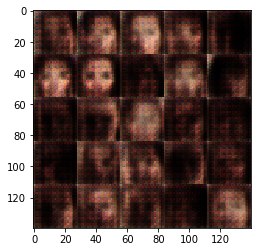

Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8830
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


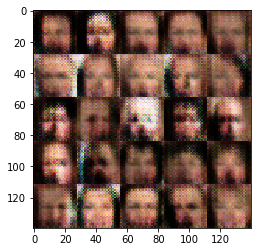

Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8106
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


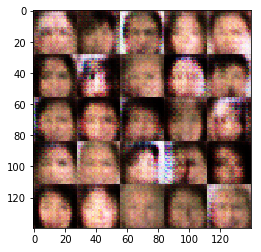

Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7330
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


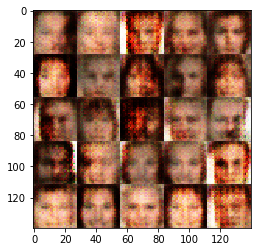

Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 1.0724
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.9385... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.7953
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


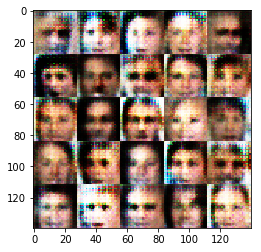

Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.9101... Generator Loss: 2.1575
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.4035
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


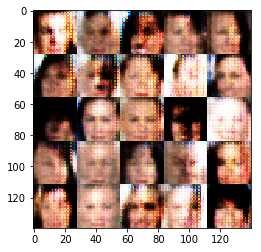

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.7630
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


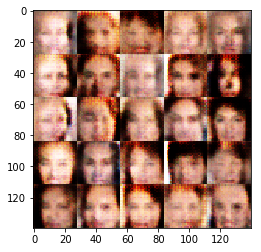

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8204
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


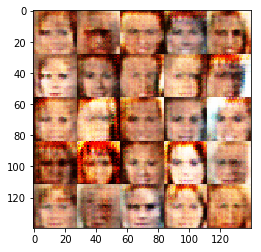

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7868
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


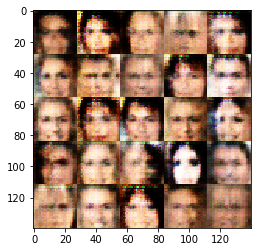

Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7262
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


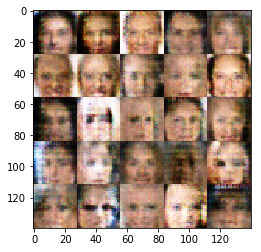

Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6412
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


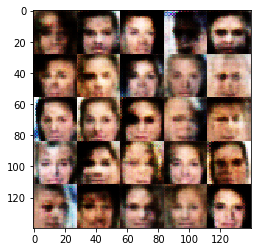

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 2.1178... Generator Loss: 2.1208
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


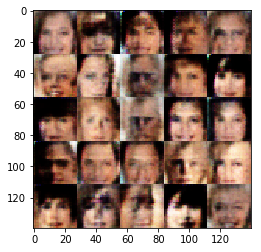

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5696
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


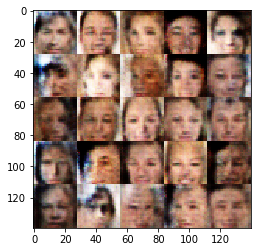

Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.8276... Generator Loss: 0.2947
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.8828
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


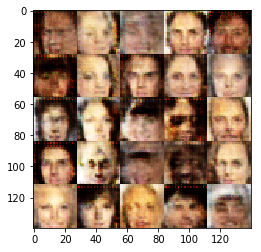

Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 1.2819
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.9577
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


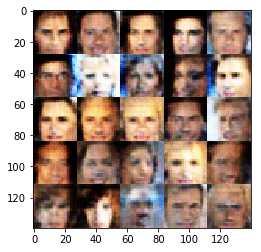

Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.8211
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


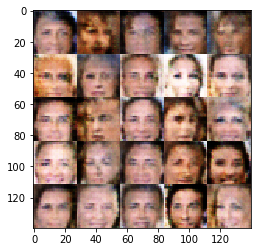

Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7094
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


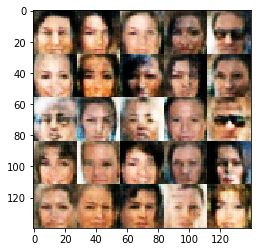

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.5104
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5645
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


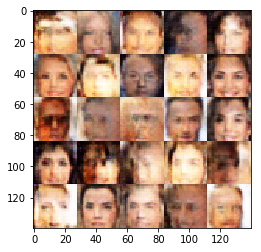

Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.6967
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


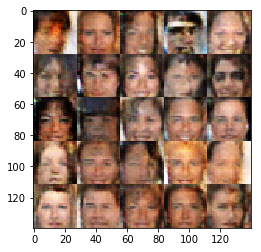

Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.6580
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


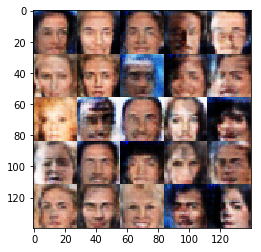

Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.4925
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


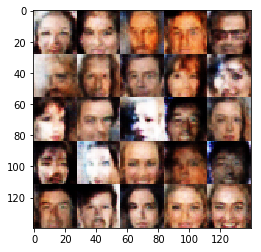

Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.9212
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


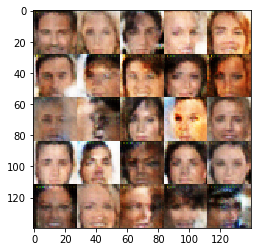

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.5442
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


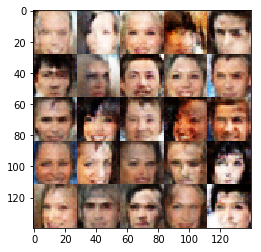

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8342
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


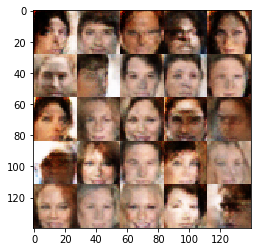

Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.6071... Generator Loss: 0.4033
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6489
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


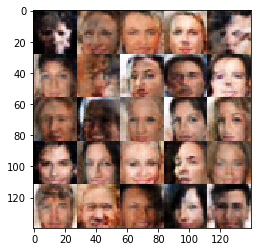

Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.8532
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


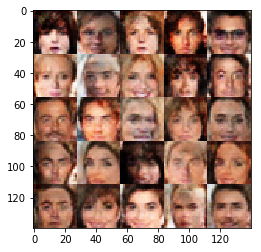

Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6054
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


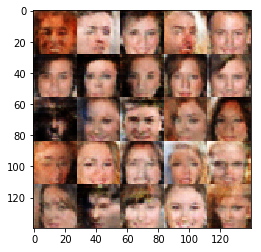

Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.5792
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 128)
LRELU3 (?, 14, 14, 64)
LRELU4 (?, 28, 28, 32)


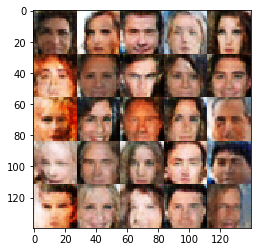

Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.5145


KeyboardInterrupt: 

In [88]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.